## Capstone Project 1

### Data preparation

In [2]:
import pandas as pd
import numpy as np
import seaborn as sns
from matplotlib import pyplot as plt
%matplotlib inline

data = pd.read_csv("ford_car_price_prediction.csv")
data.head(10)

,model,year,price,transmission,mileage,fuelType,tax,mpg,engineSize
0,Fiesta,2017,12000,Automatic,15944,Petrol,150,57.7,1.0
1,Focus,2018,14000,Manual,9083,Petrol,150,57.7,1.0
2,Focus,2017,13000,Manual,12456,Petrol,150,57.7,1.0
3,Fiesta,2019,17500,Manual,10460,Petrol,145,40.3,1.5
4,Fiesta,2019,16500,Automatic,1482,Petrol,145,48.7,1.0
5,Fiesta,2015,10500,Manual,35432,Petrol,145,47.9,1.6
6,Puma,2019,22500,Manual,2029,Petrol,145,50.4,1.0
7,Fiesta,2017,9000,Manual,13054,Petrol,145,54.3,1.2
8,Kuga,2019,25500,Automatic,6894,Diesel,145,42.2,2.0
9,Focus,2018,10000,Manual,48141,Petrol,145,61.4,1.0


In [14]:
data.describe()

,year,price,mileage,tax,mpg,enginesize
count,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000
mean,2016.993836,12280.198630,21907.027397,108.205479,58.609726,1.361438
std,1.632212,4447.710936,15874.464065,62.334075,9.577440,0.436243
min,2013.000000,3691.000000,5.000000,0.000000,20.900000,1.000000
25%,2016.000000,9000.000000,10174.000000,30.000000,54.300000,1.000000
50%,2017.000000,11199.000000,17863.500000,145.000000,58.900000,1.200000
75%,2018.000000,14998.000000,29859.750000,145.000000,65.700000,1.500000
max,2020.000000,42489.000000,88927.000000,570.000000,88.300000,5.000000


In [15]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1460 entries, 0 to 1459
Data columns (total 9 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   model         1460 non-null   object 
 1   year          1460 non-null   int64  
 2   price         1460 non-null   int64  
 3   transmission  1460 non-null   object 
 4   mileage       1460 non-null   int64  
 5   fueltype      1460 non-null   object 
 6   tax           1460 non-null   int64  
 7   mpg           1460 non-null   float64
 8   enginesize    1460 non-null   float64
dtypes: float64(2), int64(4), object(3)
memory usage: 102.8+ KB


In [16]:
data.isnull().sum()

model           0
year            0
price           0
transmission    0
mileage         0
fueltype        0
tax             0
mpg             0
enginesize      0
dtype: int64

In [17]:
print("Dataset dimensions:", data.shape)

Dataset dimensions: (1460, 9)


In [18]:
target_label = 'price'
data.columns = data.columns.str.lower().str.replace(' ', '_')
data.columns

Index(['model', 'year', 'price', 'transmission', 'mileage', 'fueltype', 'tax',
       'mpg', 'enginesize'],
      dtype='object')

In [20]:
categorical_cols = ['model', 'transmission', 'fueltype']
numerical_cols = ['year', 'mileage', 'tax', 'mpg', 'enginesize']
y = data[[target_label]]

### 2. Exploratory Data Analysis (EDA)

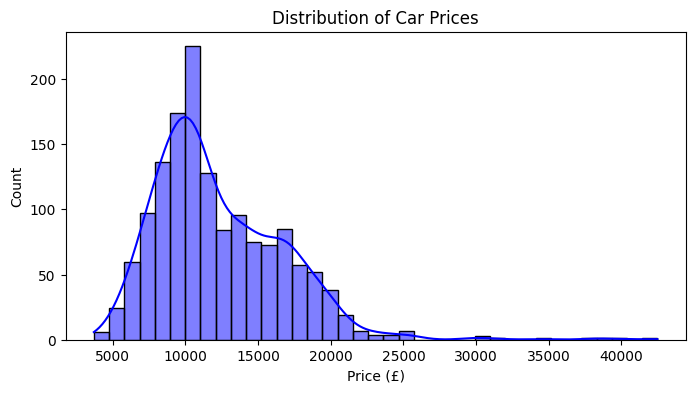

In [21]:
plt.figure(figsize=(8,4))
sns.histplot(data[target_label], kde=True, color='blue')
plt.title("Distribution of Car Prices")
plt.xlabel("Price (£)")
plt.ylabel("Count")
plt.show()

In [22]:
for col in categorical_cols:
    print(f"{col} unique values and counts:")
    print(data[col].value_counts())
    print()

model unique values and counts:
model
Fiesta                   497
Focus                    413
Kuga                     198
EcoSport                  94
C-MAX                     57
Ka+                       53
Mondeo                    26
B-MAX                     25
Grand C-MAX               19
S-MAX                     13
Edge                      11
Tourneo Custom            11
Grand Tourneo Connect      8
KA                         8
Puma                       7
Galaxy                     7
Mustang                    7
Tourneo Connect            6
Name: count, dtype: int64

transmission unique values and counts:
transmission
Manual       1313
Semi-Auto      78
Automatic      69
Name: count, dtype: int64

fueltype unique values and counts:
fueltype
Petrol    944
Diesel    515
Hybrid      1
Name: count, dtype: int64



In [30]:
def plotCategoryDistribution(df, column_name, title):
    # Contagem de valores
    col_counts = df[column_name].value_counts().reset_index()
    col_counts.columns = [column_name, 'count']

    plt.figure(figsize=(8, 8))
    explode = [0.01] * len(col_counts)
    plt.pie(col_counts['count'], labels=col_counts[column_name], autopct='%1.1f%%', explode=explode)
    plt.title(f"{title} Distribution")
    plt.show()

def plotImpactOnPrice(df, column_name, title, target_label='price'):
    col_price = df.groupby(column_name)[target_label].mean().reset_index().sort_values(by=target_label)
    plt.figure(figsize=(10, 6))
    sns.lineplot(x=column_name, y=target_label, data=col_price, marker='o')
    plt.title(f"Impact of '{title}' on {target_label.capitalize()}")
    plt.xlabel(title)
    plt.ylabel(f"Average {target_label.capitalize()}")
    # Rotacionar labels se for necessário
    plt.xticks(rotation=90)
    plt.tight_layout()
    plt.show()

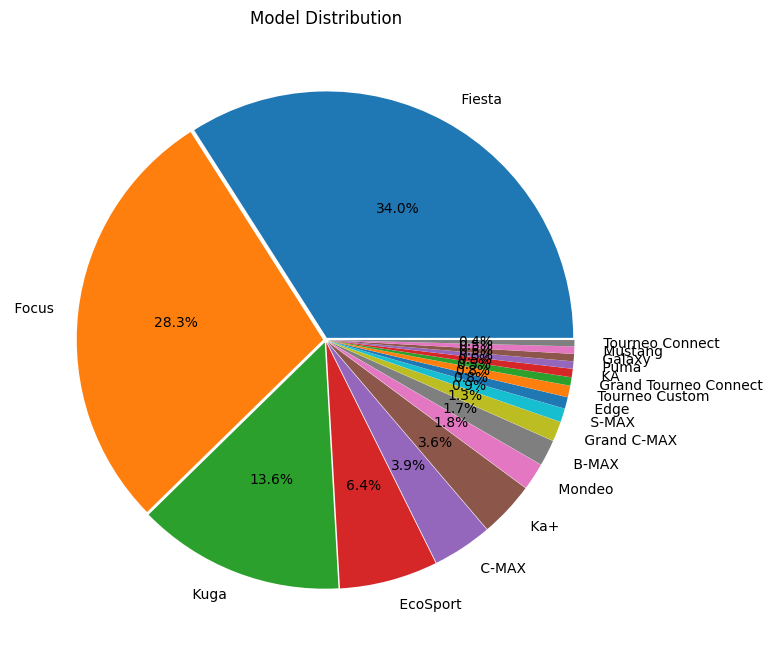

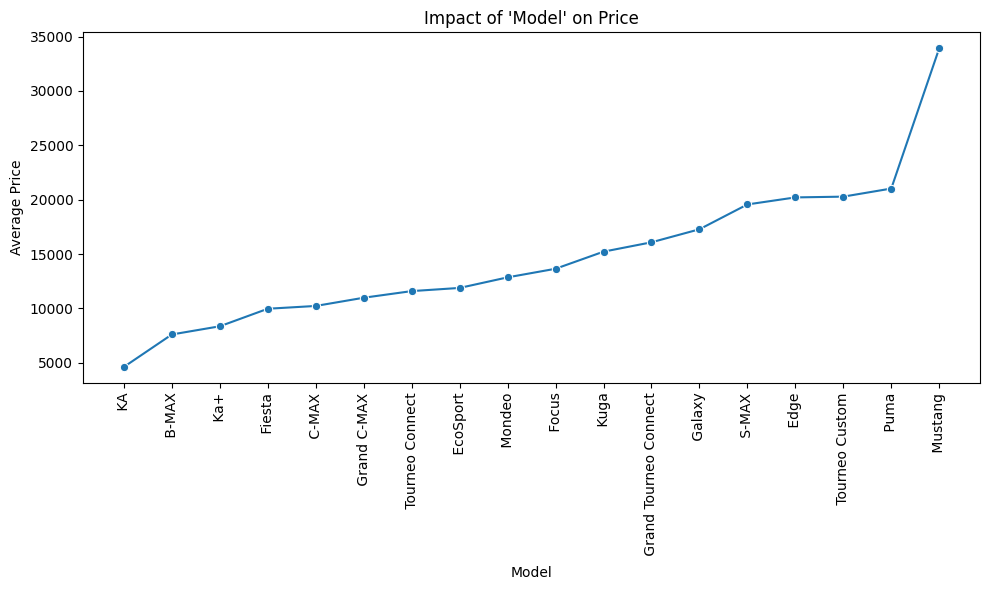

In [32]:
plotCategoryDistribution(data, 'model', 'Model')
plotImpactOnPrice(data, 'model', 'Model')

### 2.1 Relação entre preço e variáveis categóricas usando violinplot

/tmp/ipykernel_888/1804504964.py:2: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.violinplot(x='transmission', y='price', data=data, palette='pastel')


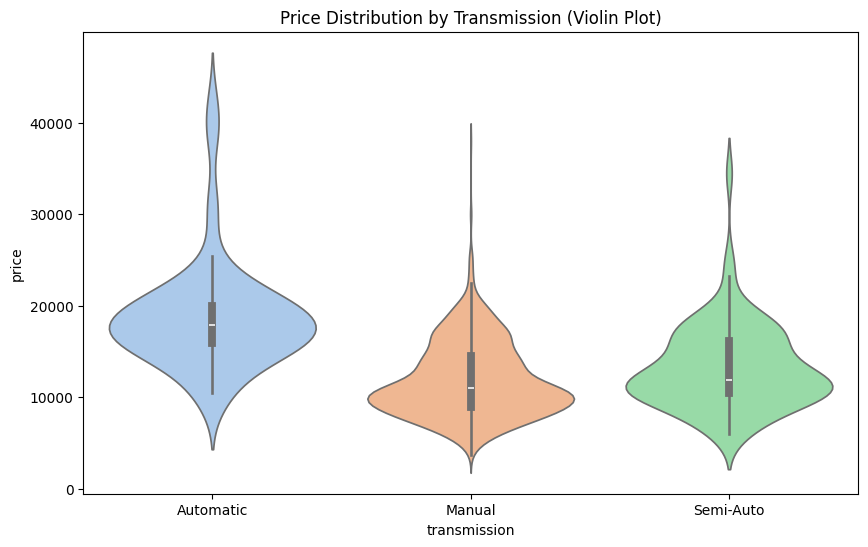

In [38]:
plt.figure(figsize=(10,6))
sns.violinplot(x='transmission', y='price', data=data, palette='pastel')
plt.title("Price Distribution by Transmission (Violin Plot)")
plt.show()

/tmp/ipykernel_888/2768040017.py:2: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.violinplot(x='fueltype', y='price', data=data, palette='pastel')


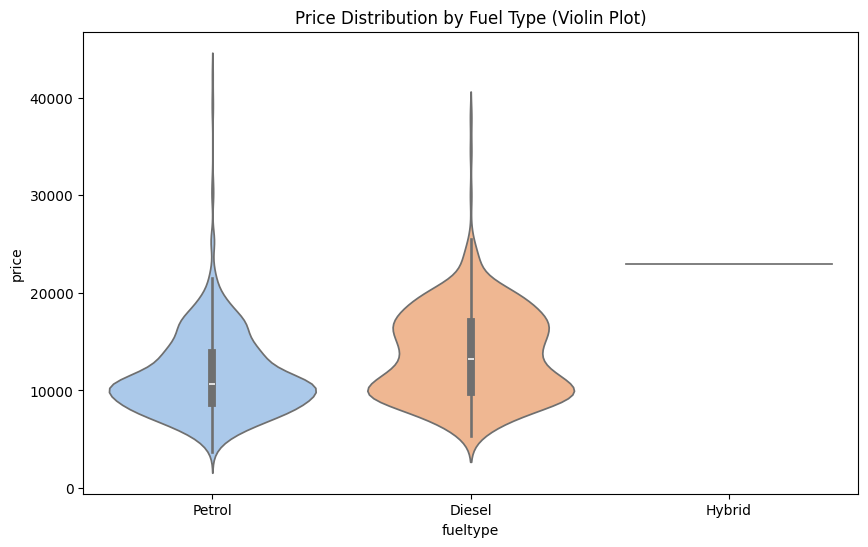

In [37]:
plt.figure(figsize=(10,6))
sns.violinplot(x='fueltype', y='price', data=data, palette='pastel')
plt.title("Price Distribution by Fuel Type (Violin Plot)")
plt.show()

### 2.2 Relação entre variáveis numéricas com hue categórico

In [ ]:
plt.figure(figsize=(10,6))
sns.scatterplot(x='mileage', y='price', hue='fueltype', data=data, alpha=0.7)
plt.title("Mileage vs Price by Fuel Type")
plt.show()